# Customer churn and survival analysis in telecom

The main goal of this notebook is to perform survival analysis on the dataset. In the case of this telecom problem the goal of survival analysis is to find the expected probability of survival (not churning) for customers during their subscription. Also finding the effect of different variables on the survival probability.

The following survival analysis methods are applied here:
 - **Kaplan-meyer survival curves** 
 - **Cox-proportional hazard model** 

Note: the **lifelines** library is used for survival analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from lifelines import KaplanMeierFitter
from lifelines.fitters.coxph_fitter import CoxPHFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import pairwise_logrank_test, proportional_hazard_test
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Load and prepare the data

In [2]:
# read the data that we preprocessed in Preprocessing notebook
preprocessed_data = pd.read_csv('preprocessed_data_telecom.csv')
preprocessed_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,Not senior,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,Not senior,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,Not senior,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,Not senior,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,Not senior,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Check for null values
preprocessed_data.isnull().sum() # Therefore there is no missing values

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

#### Encode churn column

In [4]:
# Convert churn from 'No' and 'Yes' to 0 and 1
preprocessed_data['Churn'] = preprocessed_data['Churn'].replace({'Yes':1, 'No':0})

In [5]:
# Check type of data in each column
preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   object 
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [6]:
# Get statistics of the numerical data
preprocessed_data.describe()

,tenure,MonthlyCharges,TotalCharges,Churn
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441,0.265785
std,24.545260,30.085974,2266.771362,0.441782
min,1.000000,18.250000,18.800000,0.000000
25%,9.000000,35.587500,401.450000,0.000000
50%,29.000000,70.350000,1397.475000,0.000000
75%,55.000000,89.862500,3794.737500,1.000000
max,72.000000,118.750000,8684.800000,1.000000


# Kaplan-Meyer survival curves

The Kaplan-meyer survival analysis is a non-parametric method to estimate the probability of survival based on the observed survival times (tenure) of individuals in the study. This method is a great visualization method which acts as a prescriptive survival analysis technique. This method is a univeariate technique and can not describe simultaneous effects of variables on survival probability.

In [7]:
survival_data = preprocessed_data

### Perform Kaplan-Meyer survival analysis for the dataset

This will result in the survival curve for an **average or typical customer**

In [8]:
# convert tenure to float
survival_data = survival_data.astype({"tenure": float})
survival_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   object 
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   float64
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [9]:
Tenure = survival_data[['tenure']]
Tenure.head()

,tenure
0,1.0
1,34.0
2,2.0
3,45.0
4,2.0


In [10]:
Churn = survival_data[['Churn']]
Churn.head()

,Churn
0,0
1,0
2,1
3,0
4,1


In [11]:
kmf = KaplanMeierFitter(alpha=0.05)
kmf.fit(Tenure,event_observed=Churn, label = 'Typical (average) customers')

<lifelines.KaplanMeierFitter:"Typical (average) customers", fitted with 7032 total observations, 5163 right-censored observations>

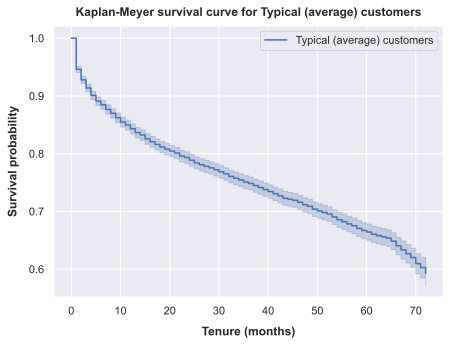

In [12]:
fig, ax = plt.subplots(figsize=(7,5))
kmf.plot(ax=ax)
#kmf.survival_function_.plot(ax=ax)
#kmf.confidence_interval_survival_function_.plot(ax=ax)
ax.set_xlabel ('Tenure (months)', labelpad=10, fontweight='bold')
ax.set_ylabel ('Survival probability', labelpad=10, fontweight='bold')
ax.set_title ('Kaplan-Meyer survival curve for Typical (average) customers', pad=10, fontweight='bold');
imagename = '3_1_KM_survival_typical_customer'
plt.savefig(f'./images/{imagename}.svg')

In [13]:
kmf.survival_function_.loc[24]

Typical (average) customers    0.788736
Name: 24.0, dtype: float64

The above figure shows the survival curve for an average (typical) customer. Each point on this curve corresponds the probability of survival for an average customer at a given time. For example the average customer is expected to survive (stay subscribed) for two years with a probability of about 78%.

### Stratify the Kaplan-Meyer curves for categorical variables

We can group the categorical variables, and calculate the Kaplan-Meyer curves for each strata. This will allow us to analyze the effect of categories in a variable on the survival.

To check whether or not the groups are statistically differernt, we perform **log-rank test**.

In [14]:
# stratify data in categorical columns and plot the results
def plot_km(survival_data, col, Tenure, Churn, imagename):
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111)
    for r in survival_data[col].unique():
        ix = survival_data[col] == r
        kmf.fit(Tenure[ix], Churn[ix],label=r)
        kmf.plot(ax=ax)
    ax.set_title(f'Survival curves, stratified by {col}', pad=10, fontweight='bold')
    ax.set_xlabel ('Tenure (months)', labelpad=10, fontweight='bold')
    ax.set_ylabel ('Survival probability', labelpad=10, fontweight='bold')
    plt.savefig(f'./images/{imagename}.svg')
    
# perform log_rank test for groups in a given column
def logrank_test(survival_data, col):
    StatisticalResult = pairwise_logrank_test(Tenure, survival_data[col], Churn)
    return StatisticalResult.summary

#### 1. Stratify by **Gender**

,,test_statistic,p,-log2(p)
Female,Male,0.525707,0.468417,1.094134


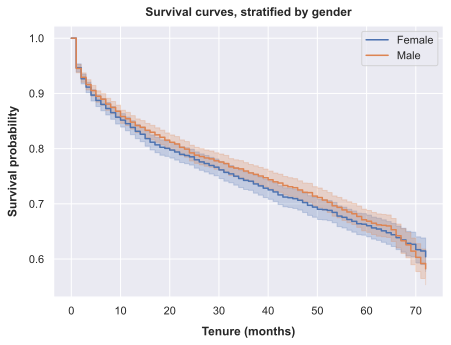

In [15]:
col = 'gender'
imagename = f'3_2_KM_survival_stratified_by_{col}'
plot_km(survival_data, col, Tenure, Churn, imagename)
logrank_test(survival_data, col)

- Based on the p-value of the log-rank test, **gender groups are NOT statistically significantly different**.

#### 2. Stratify by **Seniority**

,,test_statistic,p,-log2(p)
Not senior,Senior,109.489693,1.267619e-25,82.706081


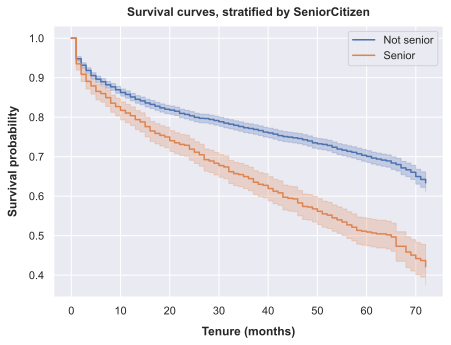

In [16]:
col = 'SeniorCitizen'
imagename = f'3_3_KM_survival_stratified_by_{col}'
plot_km(survival_data, col, Tenure, Churn, imagename)
logrank_test(survival_data, col)

- Based on the p-value of the log-rank test, **groups of senior and non-senior customers are statistically significantly different**.
- The graph shows that the survival probability for non-senior customers is higher.

#### 3.  Stratify by **Partner**

,,test_statistic,p,-log2(p)
No,Yes,423.543082,4.132951e-94,310.214069


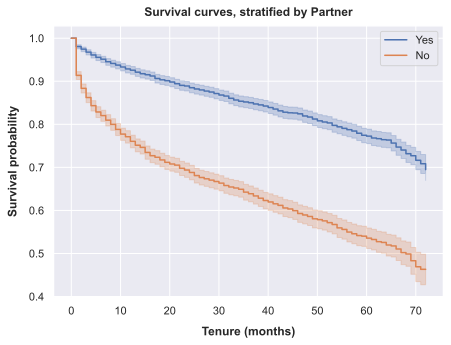

In [17]:
col = 'Partner'
imagename = f'3_4_KM_survival_stratified_by_{col}'
plot_km(survival_data, col, Tenure, Churn, imagename)
logrank_test(survival_data, col)

- Based on the p-value of the log-rank test, **groups of customers with and without partner are statistically significantly different**.
- The graph shows that the survival probability for customers with a partner is higher.

#### 4. Stratify by **Dependents**

,,test_statistic,p,-log2(p)
No,Yes,232.699042,1.537238e-52,172.11992


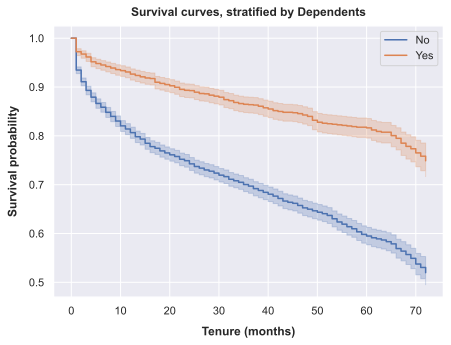

In [18]:
col = 'Dependents'
imagename = f'3_5_KM_survival_stratified_by_{col}'
plot_km(survival_data, col, Tenure, Churn, imagename)
logrank_test(survival_data, col)

- Based on the p-value of the log-rank test, **groups of customers with and without dependents are statistically significantly different**.
- The graph shows that the survival probability for customers with dependent is higher.

#### 5. Stratify by **PhoneService**

,,test_statistic,p,-log2(p)
No,Yes,0.430819,0.511588,0.966947


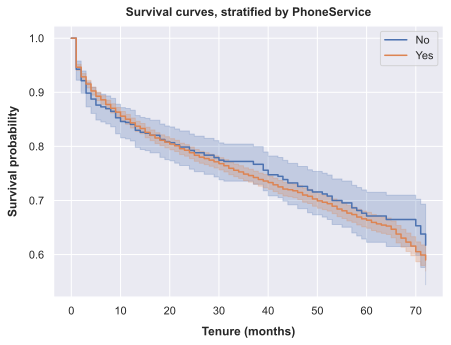

In [19]:
col = 'PhoneService'
imagename = f'3_6_KM_survival_stratified_by_{col}'
plot_km(survival_data, col, Tenure, Churn, imagename)
logrank_test(survival_data, col)

- Based on the p-value of the log-rank test, **groups of customers with and without phone service are NOT statistically significantly different**.

#### 6. Stratify by **MultipleLines**

test_statistic             p   -log2(p)
No               No phone service        3.370947  6.635560e-02   3.913638
                 Yes                    31.262663  2.253726e-08  25.403113
No phone service Yes                     1.561568  2.114358e-01   2.241709

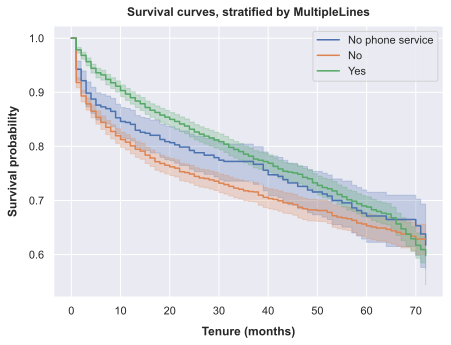

In [20]:
col = 'MultipleLines'
imagename = f'3_7_KM_survival_stratified_by_{col}'
plot_km(survival_data, col, Tenure, Churn, imagename)
logrank_test(survival_data, col)

- Based on the p-values of the log-rank test: 
 1. **only groups of customers with and without MultipleLines are statistically significantly different**.
 2. groups of customers with 'No phone service' are **NOT** statically significantly different from other customers

#### 7. Stratify by **InternetService**

test_statistic             p    -log2(p)
DSL         Fiber optic      227.174973  2.462919e-51  168.117964
            No                80.317890  3.187699e-19   61.444119
Fiber optic No               374.157435  2.328119e-83  274.500867

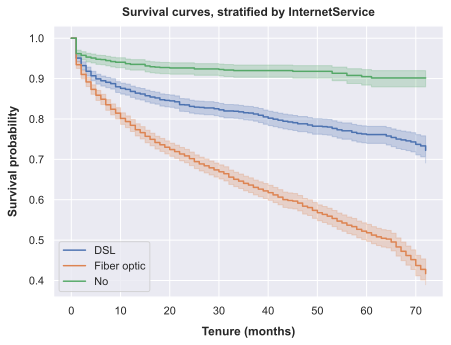

In [21]:
col = 'InternetService'
imagename = f'3_8_KM_survival_stratified_by_{col}'
plot_km(survival_data, col, Tenure, Churn, imagename)
logrank_test(survival_data, col)

- Based on the p-values of the log-rank test, **all pairs of groups of customers categorized by internet service are statistically significantly different**.
- The graph shows that the customers without internet service have the highest probability of survival and customers with Fiber optic internet service have the lowest survival probability.

#### 8. Stratify by **OnlineSecurity**

test_statistic              p  \
No                  No internet service      485.975805  1.070135e-107   
                    Yes                      660.525069  1.148535e-145   
No internet service Yes                       11.060731   8.817539e-04   

                                           -log2(p)  
No                  No internet service  355.348514  
                    Yes                  481.479779  
No internet service Yes                   10.147336

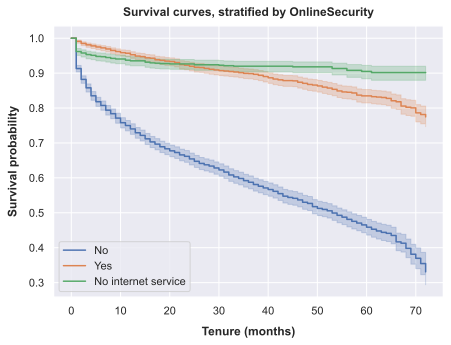

In [22]:
col = 'OnlineSecurity'
imagename = f'3_9_KM_survival_stratified_by_{col}'
plot_km(survival_data, col, Tenure, Churn, imagename)
logrank_test(survival_data, col)

- Based on the p-values of the log-rank test, **all groups of customers categorized by Online security are statistically significantly different**.
- The graph shows that the customers without internet service have the highest probability of survival and customers with Fiber optic internet service have the lowest survival probability.

#### 9. Stratify by **OnlineBackup**

test_statistic              p  \
No                  No internet service      472.481334  9.243051e-105   
                    Yes                      498.689704  1.832589e-110   
No internet service Yes                       52.778279   3.734080e-13   

                                           -log2(p)  
No                  No internet service  345.594081  
                    Yes                  364.538207  
No internet service Yes                   41.284312

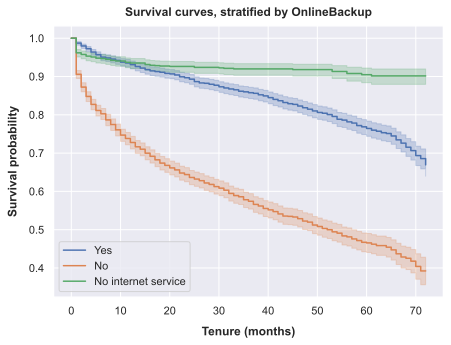

In [23]:
col = 'OnlineBackup'
imagename = f'3_10_KM_survival_stratified_by_{col}'
plot_km(survival_data, col, Tenure, Churn, imagename)
logrank_test(survival_data, col)

- Based on the p-values of the log-rank test, **all groups of customers categorized by Online backup are statistically significantly different**.
- The graph shows that the customers without internet service have the highest probability of survival and customers without Onlinebackup service have lower probability of survival compared to the customers that have Onlinebackup service.

#### 10. Stratify by **DeviceProtection**

test_statistic              p  \
No                  No internet service      461.819756  1.931446e-102   
                    Yes                      448.469744   1.552897e-99   
No internet service Yes                       61.343679   4.793276e-15   

                                           -log2(p)  
No                  No internet service  337.886984  
                    Yes                  328.235919  
No internet service Yes                   47.567909

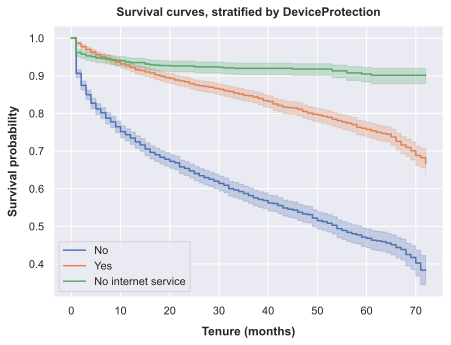

In [24]:
col = 'DeviceProtection'
imagename = f'3_11_KM_survival_stratified_by_{col}'
plot_km(survival_data, col, Tenure, Churn, imagename)
logrank_test(survival_data, col)

- Based on the p-values of the log-rank test, **all groups of customers categorized by Device Protection are statistically significantly different**.
- The graph shows that the customers without internet service have the highest probability of survival and customers without Device protection have lower probability of survival compared to the customers that have device protection service.

#### 11. Stratify by **TechSupport**

test_statistic              p  \
No                  No internet service      482.287425  6.792153e-107   
                    Yes                      639.350003  4.627058e-141   
No internet service Yes                       13.894457   1.933679e-04   

                                           -log2(p)  
No                  No internet service  352.682437  
                    Yes                  466.181766  
No internet service Yes                   12.336364

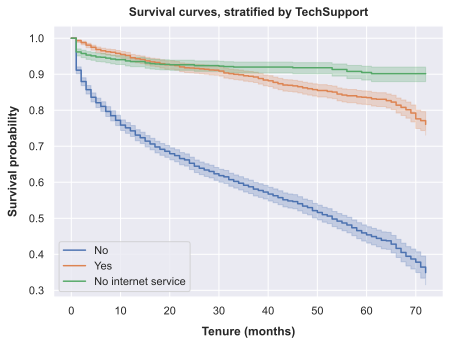

In [25]:
col = 'TechSupport'
imagename = f'3_12_KM_survival_stratified_by_{col}'
plot_km(survival_data, col, Tenure, Churn, imagename)
logrank_test(survival_data, col)

- Based on the p-values of the log-rank test, **all groups of customers categorized by TechSupport are statistically significantly different**.
- The graph shows that the customers without internet service have the highest probability of survival and customers without Tech support have lower probability of survival compared to the customers that have Tech support.

#### 12. Stratify by **StreamingTV**

test_statistic             p  \
No                  No internet service      336.023635  4.686697e-75   
                    Yes                      103.851367  2.180772e-24   
No internet service Yes                      148.309493  4.059550e-34   

                                           -log2(p)  
No                  No internet service  246.916036  
                    Yes                   78.601435  
No internet service Yes                  110.924235

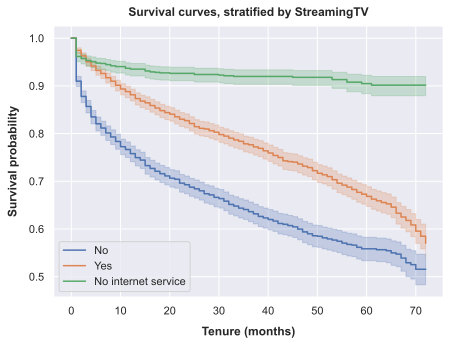

In [26]:
col = 'StreamingTV'
imagename = f'3_13_KM_survival_stratified_by_{col}'
plot_km(survival_data, col, Tenure, Churn, imagename)
logrank_test(survival_data, col)

- Based on the p-values of the log-rank test, **all groups of customers categorized by Streaming TV are statistically significantly different**.
- The graph shows that the customers without internet service have the highest probability of survival and customers without StreamingTV have lower probability of survival compared to the customers that have StreamingTV.

#### 13. Stratify by **StreamingMovies**

test_statistic             p  \
No                  No internet service      340.855999  4.153842e-76   
                    Yes                      112.792732  2.395523e-26   
No internet service Yes                      146.131713  1.214918e-33   

                                           -log2(p)  
No                  No internet service  250.412089  
                    Yes                   85.109790  
No internet service Yes                  109.342769

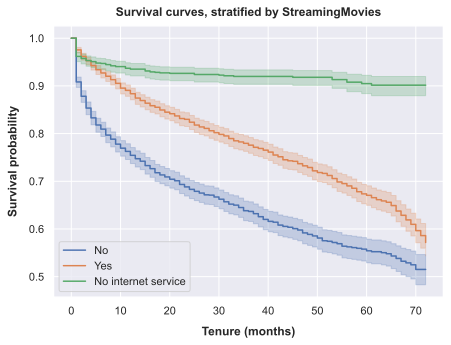

In [27]:
col = 'StreamingMovies'
imagename = f'3_14_KM_survival_stratified_by_{col}'
plot_km(survival_data, col, Tenure, Churn, imagename)
logrank_test(survival_data, col)

- Based on the p-values of the log-rank test, **all groups of customers categorized by StreamingMovies are statistically significantly different**.
- The graph shows that the customers without internet service have the highest probability of survival and customers without Streaming Movie service have lower probability of survival compared to the customers that have this service.

#### 14. Stratify by **Contract**

test_statistic              p    -log2(p)
Month-to-month One year      926.064559  2.117327e-203  673.269159
               Two year     1550.510307   0.000000e+00         inf
One year       Two year      256.217767   1.145448e-57  189.153989

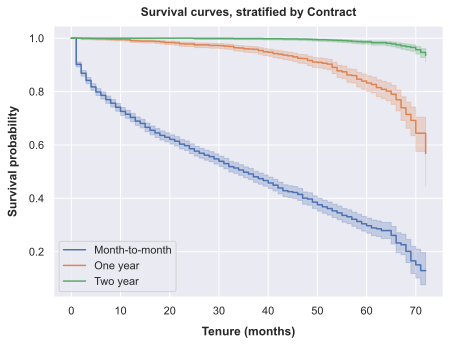

In [28]:
col = 'Contract'
imagename = f'3_15_KM_survival_stratified_by_{col}'
plot_km(survival_data, col, Tenure, Churn, imagename)
logrank_test(survival_data, col)

- Based on the p-values of the log-rank test, **all groups of customers categorized by contract are statistically significantly different**.
- The graph shows that longer contract period corresponds to increase in the survival probability.

#### 15. Stratify by **PaperlessBilling**

,,test_statistic,p,-log2(p)
No,Yes,189.511486,4.064094e-43,140.819974


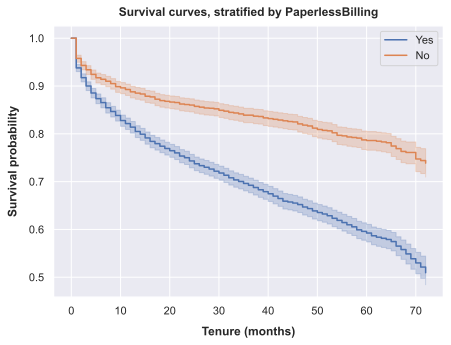

In [29]:
col = 'PaperlessBilling'
imagename = f'3_16_KM_survival_stratified_by_{col}'
plot_km(survival_data, col, Tenure, Churn, imagename)
logrank_test(survival_data, col)

- Based on the p-value of the log-rank test, **customers categorized by PaperlessBilling are statistically significantly different**.
- The graph shows that customers that use paperless billing, have higher probability of survival.

#### 16. Stratify by **PaymentMethod**

test_statistic  \
Bank transfer (automatic) Credit card (automatic)        0.868295   
                          Electronic check             510.035059   
                          Mailed check                  51.071855   
Credit card (automatic)   Electronic check             539.740177   
                          Mailed check                  64.815174   
Electronic check          Mailed check                 152.455455   

                                                               p    -log2(p)  
Bank transfer (automatic) Credit card (automatic)   3.514278e-01    1.508700  
                          Electronic check         6.231417e-113  372.738314  
                          Mailed check              8.904593e-13   40.030516  
Credit card (automatic)   Electronic check         2.147615e-119  394.206708  
                          Mailed check              8.226320e-16   50.110602  
Electronic check          Mailed check              5.038297e-35  113.934547

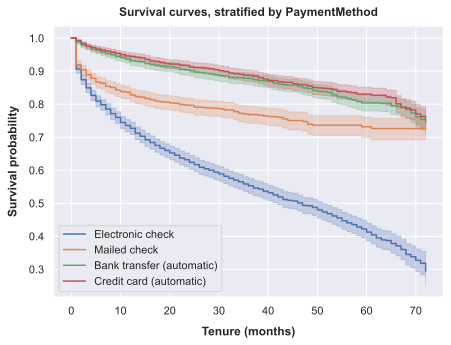

In [30]:
col = 'PaymentMethod'
imagename = f'3_17_KM_survival_stratified_by_{col}'
plot_km(survival_data, col, Tenure, Churn, imagename)
logrank_test(survival_data, col)

- Based on the p-values of the log-rank test: 
1. customers taht pay by bank transfer and customers that pay by Credit card (customers with **'automatic'** type of payment) are **NOT statistically significantly differnt**.
2. **all other pairs of groups of customers categorized by payment method are statistically significantly different**.
- The graph shows that customers that use automatic (credit card or bank transfer) Payment type have the highest probability of survival and the customers that use electronic check have the lowest probability of survival.

# Survival analysis with **Cox-Proportional Hazard Model**

The Cox-proportional hazard model is essentially a regression model that is used for investigating the effect of variables on the survival time of subjecst of study.
The main goal of this model is to evaluate simultaneous effect of variables on survival. In the case of our problem, it allows us to examine how different variables influence the rate of churn at a particular point during subscription. This rate is commonly referred as the hazard rate. 
Note that in the context of survival analyis the predictor variables (or factors) are usually termed covariates.
The cox-proportional hazardregression model could be formulated as follow:

h(t)=h0(t)×exp(b1.X1+b2.X2+...+bp.Xp)

Where t is the survival time. The coefficients (b1,b2,...,bp) measure the influence of covariates (X1, X2, ... Xp) on the hazard function (h(t)). And h0(t) is called the baseline hazard which corresponds to the value of hazard when all covariates are zero.


### Selected covariates for the cox-proportional hazard model:

Based on the results of Kaplan-Meyer survival curves and descriptive data analysis, the following variables are considered for the cox-proportional hazard regression model:

 - gender
 - SeniorCitizen
 - Partner
 - Dependents
 - PhoneService
 - InternetService
 - Contract
 - PaperlessBilling
 - MonthlyCharges
 - TotalCharges
 
Note: As an example on the selection of covariatees for the model, we did not include the StreamingMovies and StreamingTV in the model because there is high colinearity between these covariates and also with the InternetService.

### Preparing the data for the cox-proportional hazard model:

One-hot encode the categrical data and drop first column.

In [31]:
survival_data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [32]:
# Selected columns for cph model:
selected_cols = ['gender', 'SeniorCitizen','Partner','Dependents','tenure','PhoneService','InternetService',\
                 'Contract','PaperlessBilling','MonthlyCharges','TotalCharges','Churn']

cph_df = survival_data[selected_cols]
cph_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
0,Female,Not senior,Yes,No,1.0,No,DSL,Month-to-month,Yes,29.85,29.85,0
1,Male,Not senior,No,No,34.0,Yes,DSL,One year,No,56.95,1889.50,0
2,Male,Not senior,No,No,2.0,Yes,DSL,Month-to-month,Yes,53.85,108.15,1
3,Male,Not senior,No,No,45.0,No,DSL,One year,No,42.30,1840.75,0
4,Female,Not senior,No,No,2.0,Yes,Fiber optic,Month-to-month,Yes,70.70,151.65,1


In [33]:
#encode categorical columns
cph_df_encoded = pd.get_dummies(cph_df, drop_first=True)
cph_df_encoded.head()

,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,SeniorCitizen_Senior,Partner_Yes,Dependents_Yes,PhoneService_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaperlessBilling_Yes
0,1.0,29.85,29.85,0,0,0,1,0,0,0,0,0,0,1
1,34.0,56.95,1889.50,0,1,0,0,0,1,0,0,1,0,0
2,2.0,53.85,108.15,1,1,0,0,0,1,0,0,0,0,1
3,45.0,42.30,1840.75,0,1,0,0,0,0,0,0,1,0,0
4,2.0,70.70,151.65,1,0,0,0,0,1,1,0,0,0,1


Note that the droped covariates are the baseline covariates.

### Fit the cox-proportional hazard model

In [34]:
cph = CoxPHFitter()
cph.fit(cph_df_encoded, duration_col='tenure', event_col='Churn')

<lifelines.CoxPHFitter: fitted with 7032 total observations, 5163 right-censored observations>

In [35]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7032 total observations, 5163 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7032
number of events observed = 1869
   partial log-likelihood = -12718.69
         time fit was run = 2021-06-10 17:40:34 UTC

---
                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                           
MonthlyCharges                0.03       1.03       0.00             0.03             0.04                 1.03                 1.04
TotalCharges                 -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
gender_Male                  -0.02       0.98       0.05            -0.11             0.07                 0.90                 1.08
SeniorCitizen_Senior          0.08       1.08       0.06            -0.03             0.19                 0.97                 1.21
Partner_Yes                  -0.19       0.83       0.05            -0.30            -0.08                 0.74                 0.92
Dependents_Yes               -0.11       0.90       0.07            -0.25             0.03                 0.78                 1.03
PhoneService_Yes              0.38       1.46       0.11             0.16             0.60                 1.17                 1.82
InternetService_Fiber optic   0.63       1.88       0.10             0.44             0.82                 1.56                 2.28
InternetService_No           -1.57       0.21       0.17            -1.91            -1.24                 0.15                 0.29
Contract_One year            -1.37       0.25       0.10            -1.57            -1.17                 0.21                 0.31
Contract_Two year            -3.86       0.02       0.20            -4.26            -3.47                 0.01                 0.03
PaperlessBilling_Yes          0.17       1.19       0.06             0.06             0.28                 1.06                 1.33

                                 z      p   -log2(p)
covariate                                           
MonthlyCharges               13.11 <0.005     127.94
TotalCharges                -40.68 <0.005        inf
gender_Male                  -0.39   0.70       0.52
SeniorCitizen_Senior          1.43   0.15       2.70
Partner_Yes                  -3.46 <0.005      10.86
Dependents_Yes               -1.59   0.11       3.16
PhoneService_Yes              3.37 <0.005      10.40
InternetService_Fiber optic   6.49 <0.005      33.40
InternetService_No           -9.24 <0.005      65.08
Contract_One year           -13.66 <0.005     138.76
Contract_Two year           -19.26 <0.005     272.26
PaperlessBilling_Yes          3.05 <0.005       8.79
---
Concordance = 0.93
Partial AIC = 25461.39
log-likelihood ratio test = 5868.69 on 12 df
-log2(p) of ll-ratio test = inf

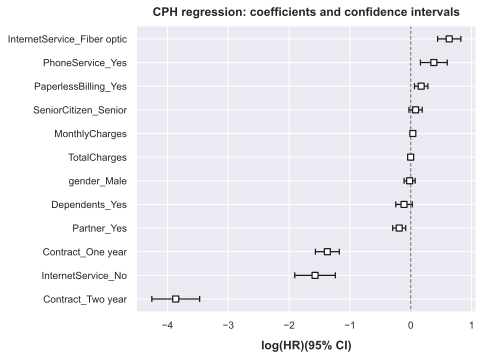

In [36]:
fig, ax = plt.subplots(figsize=(7,5))
cph.plot(ax=ax)
ax.set_title ('CPH regression: coefficients and confidence intervals', pad=10, fontweight='bold')
fig.tight_layout(w_pad=4)
ax.tick_params(axis='x', labelsize= 10)
ax.tick_params(axis='y', labelsize= 10)
ax.set_xlabel ('log(HR)(95% CI)', labelpad=10, fontweight='bold');
imagename = '3_18_CPH_regression_coefficients_and_confidence_intervals'
plt.savefig(f'./images/{imagename}.svg')

### Interprete the results

 -  Based on the p-values, it seems that 'gender_Male', 'SeniorCitizen_Senior' and 'Dependents_Yes' covariates are not significant so we can remove them from this model.
 
  In the cox-proportional hazard regression results the exp(coef) is an important term and interpreted as the scaling of the baseline hazard. For the categorical variables this term shows the ratio of hazard change from the baseline and for the numberical variables shows the scaling of hazard risk for each additional unit of the variable. For example based on the results we can argue that:
  - The customer with 'one year' contract is 0.25 as likely to churn as someone with 'month-to-month' contract which is the baseline.
  - The customer with 'two year' contract is 0.02 as likely to churn as someone with 'month-to-month' contract which is the baseline.
  - Each unit increase in MonthlyCharges corresponds to an increase in risk of churn by a factor of 1.03

### Use the model to develop survival curve for each customer

In [37]:
# Select a customer:
n = 6
selected_customer = cph_df.iloc[[n]]
selected_customer

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
6,Male,Not senior,No,Yes,22.0,Yes,Fiber optic,Month-to-month,Yes,89.1,1949.4,0


In [38]:
# Selected customer with encoded variables
selected_customer_enc = cph_df_encoded.iloc[[n]]
selected_customer_enc

,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,SeniorCitizen_Senior,Partner_Yes,Dependents_Yes,PhoneService_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaperlessBilling_Yes
6,22.0,89.1,1949.4,0,1,0,0,1,1,1,0,0,0,1


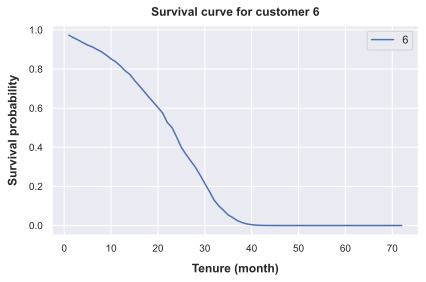

In [39]:
# plot survival curve for this customer
fig, ax = plt.subplots()
cph.predict_survival_function(selected_customer_enc).plot(ax=ax)
ax.set_title (f'Survival curve for customer {str(n)}', pad=10, fontweight='bold')
ax.tick_params(axis='x', labelsize= 10)
ax.tick_params(axis='y', labelsize= 10)
ax.set_xlabel('Tenure (month)', labelpad=10, fontweight='bold')
ax.set_ylabel('Survival probability', labelpad=10, fontweight='bold')
fig.tight_layout(w_pad=4)
imagename = '3_19_survival_curve_for_selected_customer'
plt.savefig(f'./images/{imagename}.svg')